In [1]:
import os
import sys
import cv2
import ssl
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.abspath('./detectron2/detectron2/'))
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## Detectron

In [2]:
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.DEVICE = "cpu"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

detectron = DefaultPredictor(cfg)

In [3]:
iterator = iter(list(Path("../data/test_images/mistery_category/").rglob("*.jpg")))

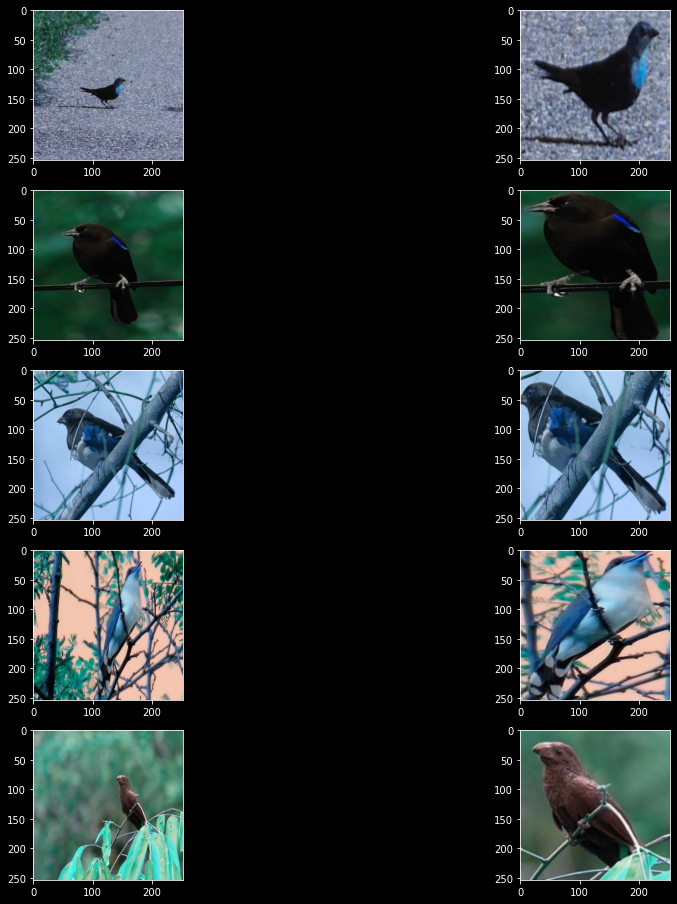

In [145]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 16))

for i in range(5):
    img_path = next(iterator)

    img = cv2.imread(str(img_path))
    width, height, _ = img.shape

    outputs = detectron(img)

    classes = outputs["instances"].get_fields()["pred_classes"]
    bird_indices = np.where(classes == 14)[0]
    if len(bird_indices) == 0:
        crop = img
    else:
        scores = outputs["instances"].get_fields()["scores"]
        for j in range(len(scores)):
            if j not in bird_indices:
                scores[j] = 0
        argmax = scores.argmax().item()
        box = outputs["instances"].get_fields()["pred_boxes"].tensor[argmax]
        left, top, right, bottom = box
        left -= 10
        right += 10
        top -= 10
        bottom += 10
        left, top, right, bottom = list(map(lambda x: int(x), (left, top, right, bottom)))
        crop = img[top:bottom, left:right]
        crop = cv2.resize(crop, (254, 254))
        img = cv2.resize(img, (254, 254))
        
        axes[i, 0].imshow(img)
        axes[i, 1].imshow(crop)
plt.show()